# Fulfillment AI — Delay Prediction Model Training

This notebook trains a binary classifier to predict delivery delays using the Kaggle E-Commerce Shipping Dataset.

**Target variable**: `Reached.on.Time_Y.N` (1 = on time, 0 = late/delayed)

For our system, we predict **delay probability** — the probability that `Reached.on.Time_Y.N == 0`.

## 1 — Setup & Data Loading

In [1]:
import json
import warnings
from datetime import datetime, timezone
from pathlib import Path

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
# Load dataset
df = pd.read_csv("../data/raw/ecommerce_shipping.csv")
print(f"Shape: {df.shape}")
print(f"\nDtypes:\n{df.dtypes}")
df.head()

Shape: (10999, 12)

Dtypes:
ID                     int64
Warehouse_block          str
Mode_of_Shipment         str
Customer_care_calls    int64
Customer_rating        int64
Cost_of_the_Product    int64
Prior_purchases        int64
Product_importance       str
Gender                   str
Discount_offered       int64
Weight_in_gms          int64
Reached.on.Time_Y.N    int64
dtype: object


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [4]:
# Drop the ID column — not a feature
df = df.drop(columns=["ID"])
print(f"Columns after drop: {list(df.columns)}")
print(f"Shape: {df.shape}")

Columns after drop: ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N']
Shape: (10999, 11)


## 2 — Exploratory Data Analysis (EDA)

In [5]:
# Missing values check
missing = df.isnull().sum()
print("Missing values per column:")
print(missing)
print(f"\nTotal missing: {missing.sum()}")

Missing values per column:
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

Total missing: 0


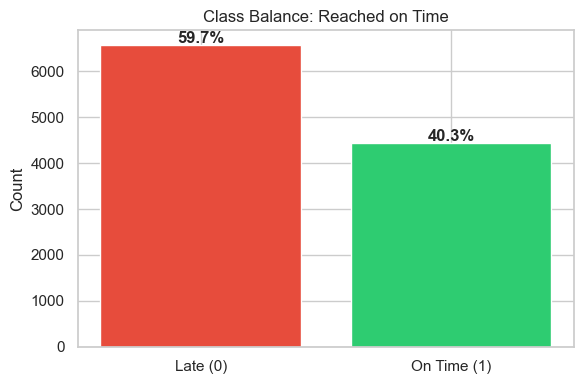


Class 0 (Late/Delayed): 4436 (40.3%)
Class 1 (On Time):      6563 (59.7%)


In [6]:
# Class balance for target variable
target_col = "Reached.on.Time_Y.N"
counts = df[target_col].value_counts()
percentages = df[target_col].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(["Late (0)", "On Time (1)"], counts.values, color=["#e74c3c", "#2ecc71"])
for bar, pct in zip(bars, percentages.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f"{pct:.1f}%", ha="center", fontweight="bold")
ax.set_title("Class Balance: Reached on Time")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

print(f"\nClass 0 (Late/Delayed): {counts[0]} ({percentages[0]:.1f}%)")
print(f"Class 1 (On Time):      {counts[1]} ({percentages[1]:.1f}%)")

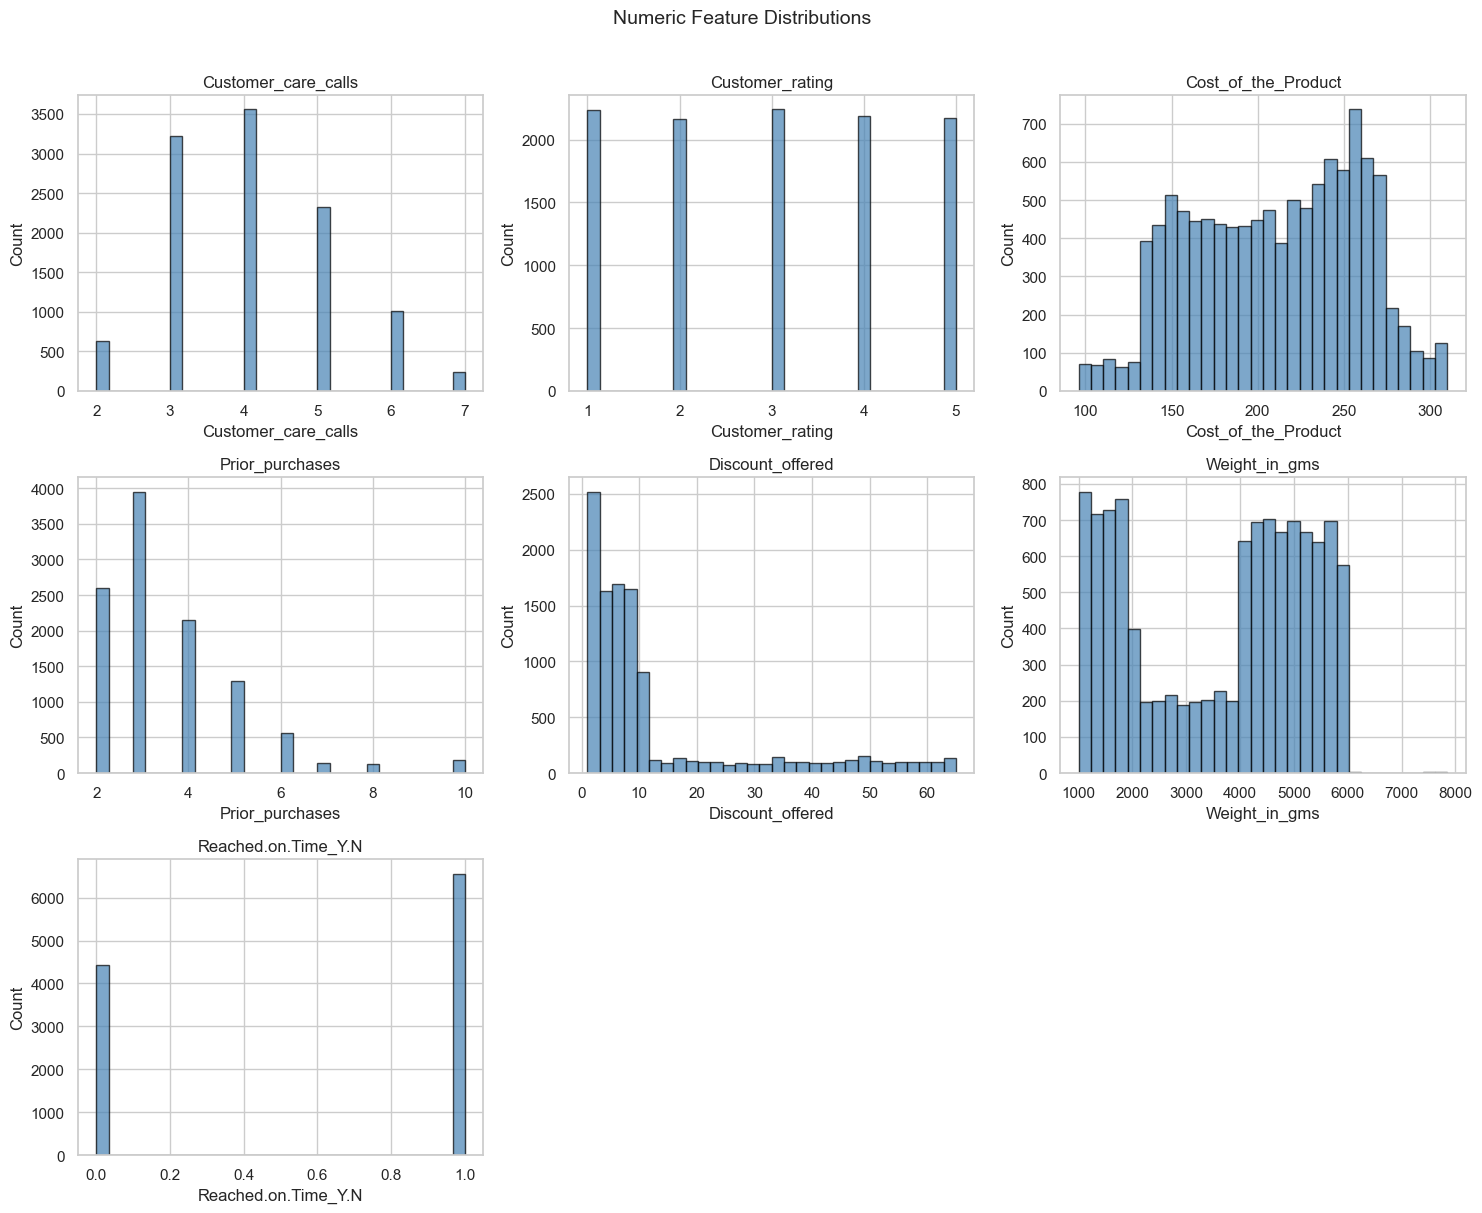

In [7]:
# Distribution histograms for numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col], bins=30, edgecolor="black", alpha=0.7, color="steelblue")
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Hide unused subplots
for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Numeric Feature Distributions", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

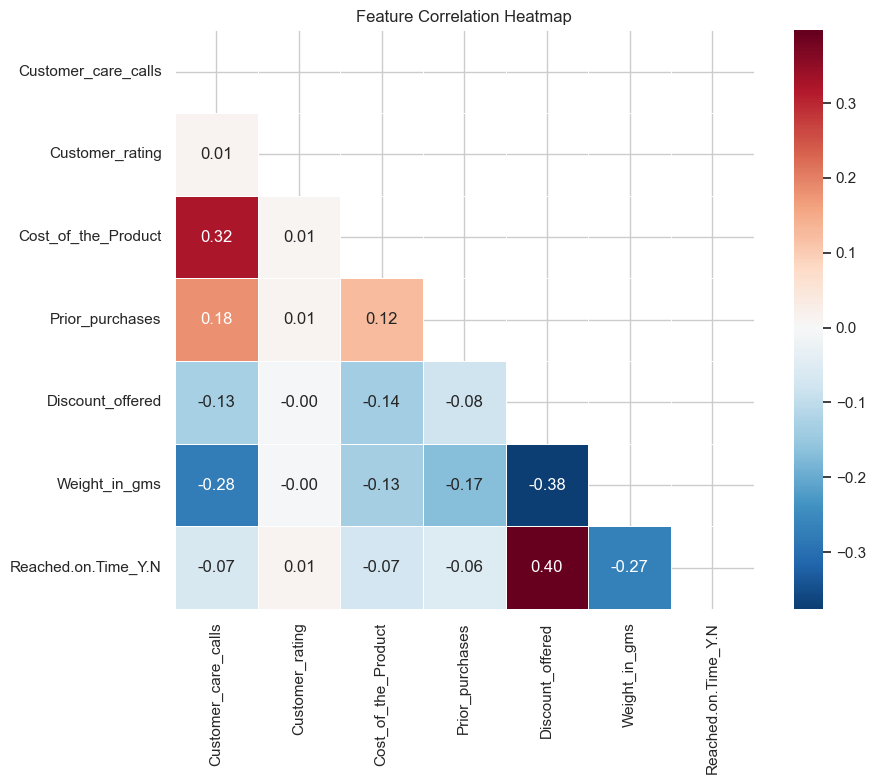

In [8]:
# Correlation heatmap
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, ax=ax, square=True, linewidths=0.5)
ax.set_title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

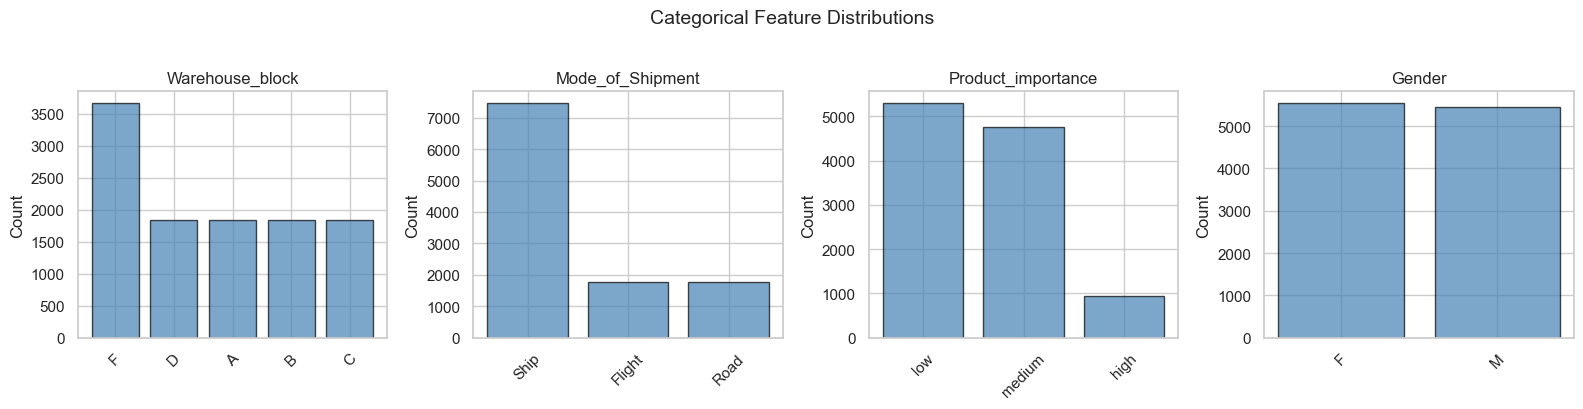


Warehouse_block:
Warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64

Mode_of_Shipment:
Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64

Product_importance:
Product_importance
low       5297
medium    4754
high       948
Name: count, dtype: int64

Gender:
Gender
F    5545
M    5454
Name: count, dtype: int64


In [9]:
# Value counts for categorical features
cat_cols = ["Warehouse_block", "Mode_of_Shipment", "Product_importance", "Gender"]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, col in enumerate(cat_cols):
    vc = df[col].value_counts()
    axes[i].bar(vc.index, vc.values, color="steelblue", edgecolor="black", alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=45)

plt.suptitle("Categorical Feature Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

for col in cat_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())

### EDA Key Findings

- **No missing values** in the dataset
- **Class balance**: The target is slightly imbalanced (~60/40 split) — manageable without resampling
- **Discount_offered** and **Weight_in_gms** show interesting distributions that may be predictive
- **Categorical features** are relatively balanced across categories
- **Low correlations** between most features — good for model independence

## 3 — Feature Engineering & Preprocessing Pipeline

In [10]:
# Define features and target
TARGET = "Reached.on.Time_Y.N"

CATEGORICAL_FEATURES = ["Warehouse_block", "Mode_of_Shipment", "Product_importance", "Gender"]
NUMERIC_FEATURES = [
    "Customer_care_calls", "Customer_rating", "Cost_of_the_Product",
    "Prior_purchases", "Discount_offered", "Weight_in_gms",
]
FEATURE_NAMES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

print(f"Total features: {len(FEATURE_NAMES)}")
print(f"Categorical: {CATEGORICAL_FEATURES}")
print(f"Numeric: {NUMERIC_FEATURES}")

X = df[FEATURE_NAMES]
y = df[TARGET]
print(f"\nX shape: {X.shape}, y shape: {y.shape}")

Total features: 10
Categorical: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
Numeric: ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

X shape: (10999, 10), y shape: (10999,)


In [11]:
# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CATEGORICAL_FEATURES),
        ("num", StandardScaler(), NUMERIC_FEATURES),
    ]
)

# Train/test split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")
print(f"Train class balance: {y_train.value_counts().to_dict()}")
print(f"Test class balance:  {y_test.value_counts().to_dict()}")

Train: 8799 samples
Test:  2200 samples
Train class balance: {1: 5250, 0: 3549}
Test class balance:  {1: 1313, 0: 887}


In [12]:
# Fit preprocessor and transform
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Transformed train shape: {X_train_transformed.shape}")
print(f"Transformed test shape:  {X_test_transformed.shape}")
print(f"\nTransformed feature count: {X_train_transformed.shape[1]}")

# Get feature names after transformation
cat_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(CATEGORICAL_FEATURES).tolist()
transformed_feature_names = cat_feature_names + NUMERIC_FEATURES
print(f"\nTransformed feature names ({len(transformed_feature_names)}):")
for name in transformed_feature_names:
    print(f"  - {name}")

Transformed train shape: (8799, 19)
Transformed test shape:  (2200, 19)

Transformed feature count: 19

Transformed feature names (19):
  - Warehouse_block_A
  - Warehouse_block_B
  - Warehouse_block_C
  - Warehouse_block_D
  - Warehouse_block_F
  - Mode_of_Shipment_Flight
  - Mode_of_Shipment_Road
  - Mode_of_Shipment_Ship
  - Product_importance_high
  - Product_importance_low
  - Product_importance_medium
  - Gender_F
  - Gender_M
  - Customer_care_calls
  - Customer_rating
  - Cost_of_the_Product
  - Prior_purchases
  - Discount_offered
  - Weight_in_gms


## 4 — Model Training & Comparison

In [13]:
# Define models
# Note: For our delay prediction system, we want P(delay) = P(Reached.on.Time_Y.N == 0)
# Since Reached.on.Time_Y.N=1 means on-time, class 0 = delayed
# sklearn's predict_proba()[:,1] gives P(class=1) = P(on time)
# So delay_probability = 1 - predict_proba()[:,1] = predict_proba()[:,0]

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200, eval_metric="logloss", random_state=42, use_label_encoder=False
    ),
    "LightGBM": lgb.LGBMClassifier(n_estimators=200, random_state=42, verbose=-1),
}

# 5-fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring="roc_auc")
    results.append({
        "Model": name,
        "Mean ROC-AUC": scores.mean(),
        "Std ROC-AUC": scores.std(),
    })
    print(f"{name:25s}  ROC-AUC: {scores.mean():.4f} (+/- {scores.std():.4f})")

results_df = pd.DataFrame(results).sort_values("Mean ROC-AUC", ascending=False)
print("\n--- Model Comparison ---")
results_df

LogisticRegression         ROC-AUC: 0.7202 (+/- 0.0075)


RandomForest               ROC-AUC: 0.7336 (+/- 0.0092)


XGBoost                    ROC-AUC: 0.7319 (+/- 0.0106)


LightGBM                   ROC-AUC: 0.7342 (+/- 0.0100)

--- Model Comparison ---


,Model,Mean ROC-AUC,Std ROC-AUC
3,LightGBM,0.734189,0.010033
1,RandomForest,0.733592,0.009170
2,XGBoost,0.731908,0.010647
0,LogisticRegression,0.720217,0.007544


In [14]:
# Select best model and refit on full training set
best_model_name = results_df.iloc[0]["Model"]
best_cv_mean = results_df.iloc[0]["Mean ROC-AUC"]
best_cv_std = results_df.iloc[0]["Std ROC-AUC"]

print(f"Best model: {best_model_name} (CV ROC-AUC: {best_cv_mean:.4f})")

best_model = models[best_model_name]
best_model.fit(X_train_transformed, y_train)
print("Model refitted on full training set.")

Best model: LightGBM (CV ROC-AUC: 0.7342)


Model refitted on full training set.


## 5 — Model Evaluation on Test Set

In [15]:
# Predict on test set
y_pred = best_model.predict(X_test_transformed)
y_pred_proba = best_model.predict_proba(X_test_transformed)[:, 1]  # P(on-time)

# Compute metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
test_f1 = f1_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Test ROC-AUC:   {test_roc_auc:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")

Test Accuracy:  0.6545
Test ROC-AUC:   0.7298
Test F1 Score:  0.6788
Test Precision: 0.7626
Test Recall:    0.6116


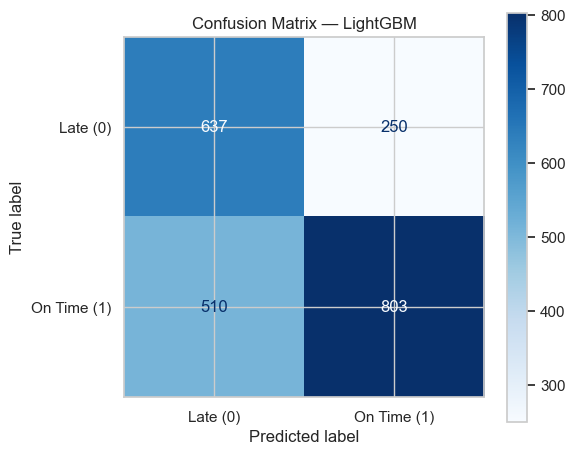

In [16]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Late (0)", "On Time (1)"])
disp.plot(ax=ax, cmap="Blues")
ax.set_title(f"Confusion Matrix — {best_model_name}")
plt.tight_layout()
plt.show()

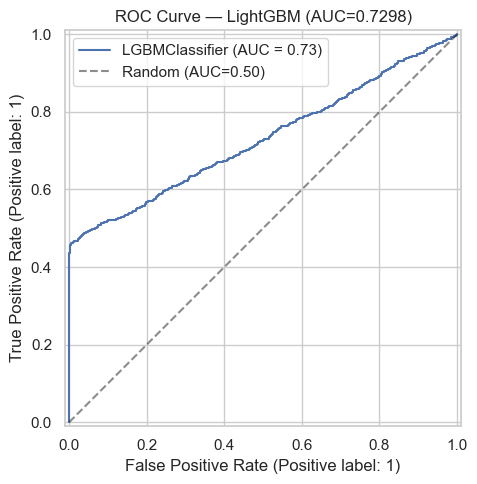

In [17]:
# ROC Curve
fig, ax = plt.subplots(figsize=(7, 5))
RocCurveDisplay.from_estimator(best_model, X_test_transformed, y_test, ax=ax)
ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Random (AUC=0.50)")
ax.set_title(f"ROC Curve — {best_model_name} (AUC={test_roc_auc:.4f})")
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
# Classification Report
print(f"Classification Report — {best_model_name}")
print("=" * 55)
print(classification_report(y_test, y_pred, target_names=["Late (0)", "On Time (1)"]))

Classification Report — LightGBM
              precision    recall  f1-score   support

    Late (0)       0.56      0.72      0.63       887
 On Time (1)       0.76      0.61      0.68      1313

    accuracy                           0.65      2200
   macro avg       0.66      0.66      0.65      2200
weighted avg       0.68      0.65      0.66      2200



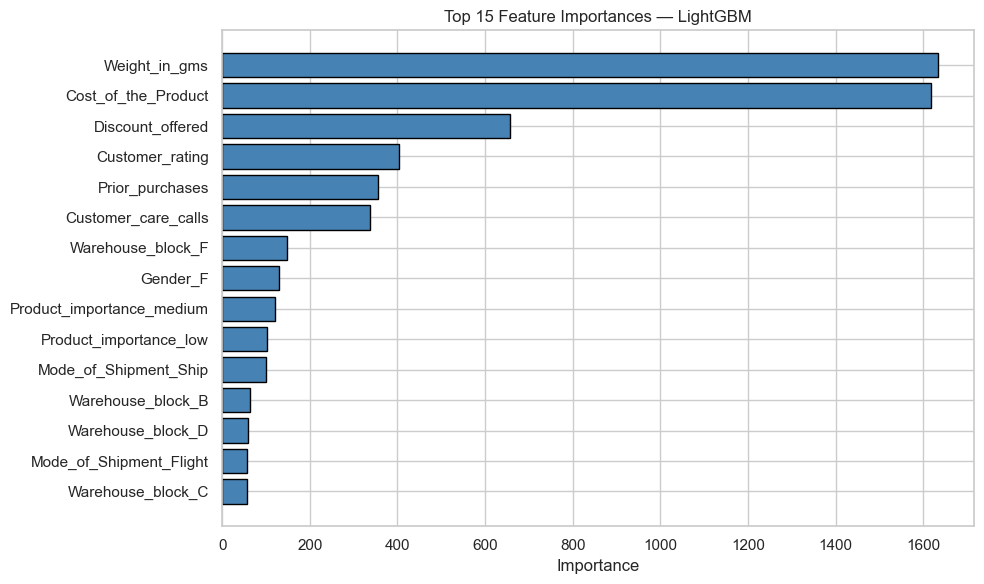

,Feature,Importance
18,Weight_in_gms,1634
15,Cost_of_the_Product,1617
17,Discount_offered,657
14,Customer_rating,404
16,Prior_purchases,356
13,Customer_care_calls,337
4,Warehouse_block_F,147
11,Gender_F,129
10,Product_importance_medium,120
9,Product_importance_low,102


In [19]:
# Feature Importance
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
elif hasattr(best_model, "coef_"):
    importances = np.abs(best_model.coef_[0])
else:
    importances = np.zeros(len(transformed_feature_names))

feat_imp = pd.DataFrame({
    "Feature": transformed_feature_names,
    "Importance": importances,
}).sort_values("Importance", ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feat_imp["Feature"][::-1], feat_imp["Importance"][::-1], color="steelblue", edgecolor="black")
ax.set_xlabel("Importance")
ax.set_title(f"Top 15 Feature Importances — {best_model_name}")
plt.tight_layout()
plt.show()

feat_imp

## 6 — Export Model Artifacts

In [20]:
# Create models directory
models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

# Save best model
model_path = models_dir / "delay_classifier.joblib"
joblib.dump(best_model, model_path)
print(f"Saved model: {model_path}")

# Save preprocessor
preprocessor_path = models_dir / "preprocessor.joblib"
joblib.dump(preprocessor, preprocessor_path)
print(f"Saved preprocessor: {preprocessor_path}")

# Save metadata
metadata = {
    "model_type": type(best_model).__name__,
    "roc_auc": round(float(test_roc_auc), 4),
    "accuracy": round(float(test_accuracy), 4),
    "f1_score": round(float(test_f1), 4),
    "precision": round(float(test_precision), 4),
    "recall": round(float(test_recall), 4),
    "feature_names": FEATURE_NAMES,
    "transformed_feature_count": int(X_train_transformed.shape[1]),
    "training_samples": int(X_train.shape[0]),
    "test_samples": int(X_test.shape[0]),
    "training_timestamp": datetime.now(timezone.utc).isoformat(),
    "cv_scores": {
        "mean": round(float(best_cv_mean), 4),
        "std": round(float(best_cv_std), 4),
    },
    "hyperparameters": {k: str(v) for k, v in best_model.get_params().items()},
}

metadata_path = models_dir / "model_metadata.json"
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata: {metadata_path}")

Saved model: ../models/delay_classifier.joblib
Saved preprocessor: ../models/preprocessor.joblib
Saved metadata: ../models/model_metadata.json


In [21]:
# Verify artifacts
print("\n--- Artifact Verification ---")

loaded_model = joblib.load(model_path)
print(f"Model loaded: {type(loaded_model).__name__}")

loaded_preprocessor = joblib.load(preprocessor_path)
print(f"Preprocessor loaded: {type(loaded_preprocessor).__name__}")

with open(metadata_path) as f:
    loaded_metadata = json.load(f)
print(f"Metadata loaded: {len(loaded_metadata)} fields")
print(f"  Model type: {loaded_metadata['model_type']}")
print(f"  ROC-AUC:    {loaded_metadata['roc_auc']}")
print(f"  Features:   {loaded_metadata['transformed_feature_count']}")

assert model_path.exists(), "Model file missing!"
assert preprocessor_path.exists(), "Preprocessor file missing!"
assert metadata_path.exists(), "Metadata file missing!"
assert loaded_metadata["roc_auc"] >= 0.65, f"ROC-AUC {loaded_metadata['roc_auc']} < 0.65!"

print("\nModel artifacts exported successfully")


--- Artifact Verification ---
Model loaded: LGBMClassifier
Preprocessor loaded: ColumnTransformer
Metadata loaded: 13 fields
  Model type: LGBMClassifier
  ROC-AUC:    0.7298
  Features:   19

Model artifacts exported successfully
